In [162]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from tqdm import tqdm
from IPython.display import clear_output


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [163]:
from src.game import Game
from src.player import Random_Player, Player

In [164]:
SEED = 42
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    

seed_everything(SEED)

In [165]:
class Collector:
    def __init__(self):
        self.X = {0: [], 1: []}
        self.y = {0: [], 1: []}
    
    def collect_info(self, X, y, table):
        temp = np.zeros(37)
        mode = len(table) % 2
        if len(table):
            temp[36] = 1
        
        #defence
        if len(table) % 2:
            X[table[-1][0], table[-1][1]] = 3
            
        self.X[mode].append(X.copy())
        for card in y:
            temp[9*card[0] + card[1]] = 1
        
        self.y[mode].append(temp.copy())
    

In [166]:
%%time
collection = Collector()
player1 = Random_Player(decetioner=collection)
player2 = Random_Player(decetioner=collection)
for i in range(10000):
    g = Game(n = 4, k = 9, take_cards=6)
    g.playing(player1, player2)
    
    player1.clear()
    player2.clear()

CPU times: total: 15.3 s
Wall time: 15.3 s


In [167]:
# Define a convolution neural network
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(4,1), stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(2,2), stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=(2,2), stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=(2,2), stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(768, 128)
        self.fc2 = nn.Linear(128, 37)
        

    def forward(self, input):
        output = F.relu(self.bn1(self.conv1(input)))      
        output = F.relu(self.bn2(self.conv2(output)))     
        output = self.pool(output)                        
        output = F.relu(self.bn4(self.conv4(output)))     
        output = F.relu(self.bn5(self.conv5(output)))     
        output = output.view(output.size(0), -1)
        output = F.relu(self.fc1(output))
        output = F.softmax(self.fc2(output), dim=1)

        return output
    

# Instantiate a neural network model 
model = Network().float()

In [168]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, mode='train', transforms=None):
        super().__init__()
        self.imgs = np.array(X).reshape(-1, 1, 4, 9)
        self.labels = y if mode in ['train', 'val'] else None
        self.mode = mode
        self.transforms = transforms
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img = self.imgs[idx]
        if self.labels is not None:
            label = self.labels[idx]
        
        if self.transforms is not None:
            img = self.transforms(image=img)['image']
        if self.mode in ['train', 'val']:
            return img, label
        return img

In [169]:
X, y = collection.X[0], collection.y[0]

X = np.array(X).reshape(-1, 1, 4, 9)
y = np.array(y)

X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

training_data = CustomDataset(X_train, y_train)
test_data = CustomDataset(X_test, y_test, mode = 'val')

train_dataloader = DataLoader(training_data, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=128, shuffle=True)

In [170]:
def plot_progress(train_losses, train_roc_aucs, test_loss, test_roc_aucs):
    clear_output(True)
    
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    f.set_figheight(6)
    f.set_figwidth(12)
    
    ax1.plot(train_losses, label='train loss')
    ax1.plot(test_loss, label='test loss')
    ax1.plot(np.zeros_like(train_losses), '--', label='zero')
    
#     Для ограничения графика loss можно пользоваться set_ylim:
    ax1.set_ylim([-0.01, 1])

    ax1.set_title('Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Batch number')
    ax1.legend()
    
    ax2.plot(train_roc_aucs, label='train cross-entropy')
    ax2.plot(test_roc_aucs, label='test cross-entropy')
#     ax2.plot(np.ones_like(train_roc_aucs), '--', label='100% roc-auc')
#     ax2.plot(np.ones_like(train_roc_aucs) * 0.5, '--', label='50% roc-auc')
    ax2.set_title('MAE')
    ax2.set_ylabel('MAE')
    ax2.set_xlabel('Batch number')
    ax2.legend()

    plt.show()

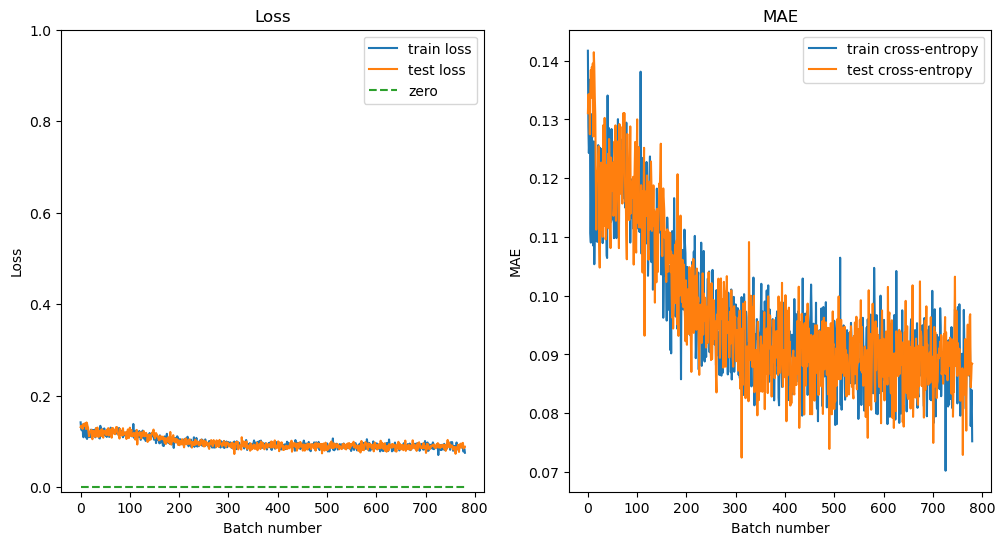

In [ ]:
loss_fn = nn.L1Loss(reduction='mean')
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

n_epochs = 5

train_roc_aucs = []
test_roc_aucs = []

train_losses = []
test_losses = []

for epoch in tqdm(range(n_epochs)):
    for data_train, target_train in train_dataloader:
        
        model.train()
        
        data_train = data_train.to(DEVICE)
        target_train = target_train.to(DEVICE)
        
        optimizer.zero_grad()

        train_preds = model(data_train)
        train_loss = loss_fn(train_preds, target_train.float())

        train_loss.backward()
        optimizer.step()

        data_test, target_test = next(iter(test_dataloader))
        model.eval()
        with torch.no_grad():
            data_test = data_test.to(DEVICE)
            target_test = target_test.to(DEVICE)

            test_preds = model(data_test)s
            test_loss = loss_fn(test_preds, target_test.float())
            
            train_losses.append(train_loss.item())
            test_losses.append(test_loss.item())
            
            train_roc_aucs.append(mean_absolute_error(target_train.cpu(), train_preds.cpu()))
            test_roc_aucs.append(mean_absolute_error(target_test.cpu(), test_preds.cpu()))

            plot_progress(train_losses, train_roc_aucs, test_losses, test_roc_aucs)

In [161]:
model = Network().float()
loss_fn = nn.BCEWithLogitsLoss(reduction='sum')
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

n_epochs = 5

train_roc_aucs = []
test_roc_aucs = []

train_losses = []
test_losses = []

for epoch in tqdm(range(n_epochs)):
    for data_train, target_train in train_dataloader:
        
        model.train()
        
        data_train = data_train.to(DEVICE)
        target_train = target_train.to(DEVICE)
        
        optimizer.zero_grad()

        train_preds = model(data_train)
        train_loss = loss_fn(train_preds, target_train.float())

        train_loss.backward()
        optimizer.step()

        data_test, target_test = next(iter(test_dataloader))
        model.eval()
        with torch.no_grad():
            data_test = data_test.to(DEVICE)
            target_test = target_test.to(DEVICE)

            test_preds = model(data_test)
            test_loss = loss_fn(test_preds, target_test.float())
            
            train_losses.append(train_loss.item())
            test_losses.append(test_loss.item())
            
            train_roc_aucs.append(mean_absolute_error(target_train.cpu(), train_preds.cpu()))
            test_roc_aucs.append(mean_absolute_error(target_test.cpu(), test_preds.cpu()))

            plot_progress(train_losses, train_roc_aucs, test_losses, test_roc_aucs)

 40%|████████████████████████████████                                                | 2/5 [47:52<1:11:48, 1436.26s/it]


KeyboardInterrupt: 

In [70]:
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)

conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5, stride=1, padding=1)

In [71]:
val = next(iter(train_dataloader))[0]

In [72]:
val.shape

AttributeError: 'list' object has no attribute 'shape'